# Monet CycleGAN


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display

import os, random, json, PIL, shutil, re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-06-24 10:25:18.638742: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 10:25:18.638851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 10:25:18.779228: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [3]:
# Configuring TPU

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

REPLICAS: 1
2.15.0


# Table of Contents
1. [Introduction](#introduction)
2. [Data Loading/Input Pipeline](#paragraph1)
3. [Model Architecture](#paragraph2)
4. [Results & Conclusions](#paragraph3)

# 1. Introduction <a name="introduction"></a>

Our goal is to build a GAN model to generate images in the style of Monet.

https://www.kaggle.com/competitions/gan-getting-started
<blockquote>
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images. 
</blockquote>

# 2. Data Loading/Input Pipeline <a name="paragraph1"></a>

In [4]:
print(os.listdir())

['__notebook__.ipynb']


### Load in Data

In [5]:
base_dir = '/kaggle/input/gan-getting-started'

MONET_FILENAMES = tf.io.gfile.glob(str(base_dir + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(base_dir + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))



Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [6]:
_, _, monet_files = next(os.walk(base_dir + '/monet_jpg'))
n_monet = len(monet_files)
print('Number of Monet files:', n_monet)

_, _, photo_files = next(os.walk(base_dir + '/photo_jpg'))
n_photos = len(photo_files)
print('Number of photo files:', n_photos)

Number of Monet files: 300
Number of photo files: 7038


In [7]:
#Inspect TFRec Structure

tmp_data = tf.data.TFRecordDataset(base_dir + '/monet_tfrec/monet00-60.tfrec')
for elt in tmp_data.take(1):
    example = tf.train.Example()
    example.ParseFromString(elt.numpy())
    for key in example.features.feature.keys(): print(key)

image_name
target
image


### Input Pipeline w/ Data Augmentation

In order to improve our models performance, we'll need to augment our images. Augmentation increases the size of our dataset and which will give more examples for our neural network to train off of. We've done this by randomly flipping and cropping the images. We will not be adjusting anything that could potentially harm the generators' ability to pick up on Monet's style (e.g. adjusting brightness, hue, contrast, saturation, or adding blur/filters). 

I have referenced this Kaggle competition as well as the Keras and tensorflow documentation for data augmentation techniques:

https://www.kaggle.com/code/dimitreoliveira/cassava-leaf-disease-cyclegan-data-augmentation#Augmentations

https://keras.io/examples/generative/cyclegan/

https://www.tensorflow.org/tutorials/images/data_augmentation

In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 4
EPOCHS_NUM = 10
REPEAT_COUNT = 2
IMAGE_SIZE = [256, 256, 3]

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.reshape(img, [*IMAGE_SIZE])
    return img

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32) / 127.5 - 1  # Map values in the range [-1, 1]
    return img

def augment_img(img):
    img = tf.image.random_flip_left_right(img)     # Random flip
    img = tf.image.random_flip_up_down(img) 
    #img = tf.image.random_brightness(img, max_delta=0.5) #Random brightness
    img = tf.image.resize(img, [286, 286])
    img = tf.image.random_crop(img, size=[*IMAGE_SIZE])

    #img = normalize_img(img)     # Normalize the pixel values in the range [-1, 1]
    return img


In [9]:
def read_tfrecord(example):
    tfrecord_format = { "image": tf.io.FixedLenFeature([], tf.string) } #only retrieves image data
    example = tf.io.parse_single_example(example, tfrecord_format)
    img = decode_img(example['image'])
    return img


def get_dataset(filenames, augment = None, repeat = False, shuffle = True, batch_size = BATCH_SIZE, buffer_size = BUFFER_SIZE):
    #ignore_order = tf.data.Options()
    #ignore_order.experimental_deterministic = False  # disable order, increase speed
    
    dataset = tf.data.TFRecordDataset(filenames)
    #dataset = dataset.with_options(ignore_order)  
    dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTOTUNE)

    #Augment images
    if augment: dataset = dataset.map(augment, num_parallel_calls = AUTOTUNE)
    dataset = dataset.map(normalize_img, num_parallel_calls=AUTOTUNE)

    if repeat: dataset = dataset.repeat(count = REPEAT_COUNT)
    if shuffle: dataset = dataset.shuffle(buffer_size)

    dataset = dataset.batch(batch_size, drop_remainder = True)
    #dataset = dataset.cache()
    #dataset = dataset.prefetch(1)

    return dataset

In [10]:
monet_ds = get_dataset(MONET_FILENAMES, augment = augment_img)
photo_ds = get_dataset(PHOTO_FILENAMES, augment = augment_img)

In [11]:
photo_ds

<_BatchDataset element_spec=TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name=None)>

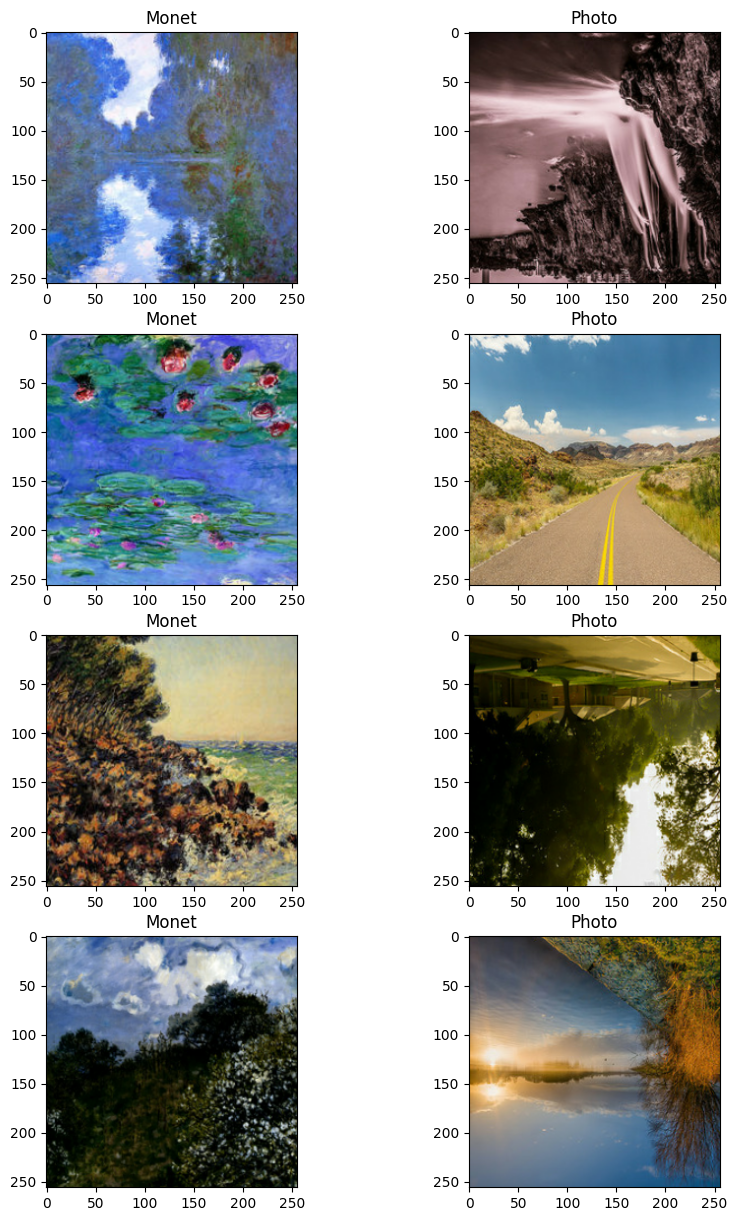

In [12]:
#Visualize augmented data

_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(monet_ds.take(4), photo_ds.take(4))):
    monet = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    photo = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(monet)
    ax[i, 0].set_title("Monet")
    ax[i, 1].imshow(photo)
    ax[i, 1].set_title("Photo")
plt.show()


# 3. Model Architecture <a name="paragraph2"></a>

Our model will have two generators, and one discriminator:

* A generator $G_m$ that attempts to convert Monet paintings to real images
* A generator $G_p$ that attempts to convert real images to Monet paintings
* A discriminator $D$ that attempts to distinguish between real images and Monet paintings.

We will be using the CycleGAN model with UNET architecture using the following resources: 

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406

https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator

We have derived our downsamplers and upsamplers (encoders/decoders) from the following resources:

https://blog.keras.io/building-autoencoders-in-keras.html

https://keras.io/examples/generative/cyclegan/

https://www.tensorflow.org/tutorials/generative/dcgan

### Downsample/Encode

* Conv2d
* Normalization
* ~~Dropout~~

In [13]:
kernel_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def downsample(
    inputs,
    n_filters,
    kernel_size=3,
    strides=2,
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
    apply_norm = True,
    #dropout_prob = 0.3
):
    x = layers.Conv2D(
        n_filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias
    )(inputs)
    if apply_norm: x = layers.BatchNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.LeakyReLU()(x)
    #x = layers.MaxPool2d(pool_size)(x)
    #x = layers.Dropout(dropout_prob)(x)
    return x



### Upsample/Encode

* Conv2d
* Skip Connection to Decoding layer
* Normalization
* ~~Dropout~~

In [14]:
def upsample(
    inputs,
    n_filters,
    kernel_size=3,
    strides=2,
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
    #apply_dropout=False
):
    x = layers.Conv2DTranspose(
        n_filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(inputs)
    x = layers.BatchNormalization(gamma_initializer=gamma_initializer)(x)

    # if apply_dropout: x = layers.Dropout(0.5)(x)
    x = layers.ReLU()(x)
    
    return x

### Residual Blocks

The purpose of these residual blocks is to help preserve features and deal with the potential issue of vanishing gradients.
* Conv2D
* Activation
* Conv2D
* Skip connection to self

In [15]:
def residual(
    x,
    kernel_size=3,
    strides=1,
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    inputs = x

    dim = x.shape[-1]

    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias
    )(inputs)

    x = layers.ReLU()(x)

    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias
    )(x)

    x = layers.BatchNormalization(gamma_initializer=gamma_initializer)(x)

    x = layers.add([inputs,x])

    return x

### Generator

For the generator, we used a similar architecture to the keras documentation.

https://keras.io/examples/generative/cyclegan/#build-the-generators

* Input layer
* Feature extraction layer
* 2 Downsample blocks
* 1 Residual/Transformation block (Conv2d w/ relu activation)
* 2 Upsample blocks
* Output layer

In [16]:

def get_generator():
    inputs = layers.Input(shape = IMAGE_SIZE)
    x = inputs
    #Downsampling blocks 
    skips = []

    x = layers.Conv2D(64, 7, kernel_initializer=kernel_init, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = downsample(x, 128)
    x = downsample(x, 256) 

    #Bottleneck/Transformation Layer
    x = residual(x)

    #Upsampling blocks
    x = upsample(x, 128)
    x = upsample(x, 64)

    #Output
    x = layers.Conv2DTranspose(3, 7, padding='same', kernel_initializer=kernel_init, activation='tanh')(x)

    return keras.Model(inputs = inputs, outputs = x)    


### Discriminator

* Input
* Conv2D
* Downsampling (3 Layers)
* Output

In [17]:
def get_discriminator(
    filters=64,
    num_downsampling = 3
):
    inputs = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inputs

    x = layers.Conv2D(64,4,strides=2,padding="same",kernel_initializer=kernel_init)(x)
    x = layers.LeakyReLU()(x)
    x = downsample(x, 128, 4)
    x = downsample(x, 256, 4)
    x = downsample(x, 512, 4, strides = 1)
    x = layers.Conv2D(1, 4, strides=1, padding = "same", kernel_initializer=kernel_init)(x)

    model = keras.models.Model(inputs=inputs, outputs=x)
    return model

In [18]:
with strategy.scope():
    monet_generator = get_generator() # transforms photos to Monet-esque paintings
    photo_generator = get_generator() # transforms Monet paintings to be more like photos

    monet_discriminator = get_discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = get_discriminator() # differentiates real photos and generated photos

In [19]:
monet_generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     73,728 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    294,912 │ leaky_re_lu[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    589,824 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    589,824 │ re_lu[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │    294,912 │ add[0][0]         │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 1,939,395 (7.40 MB)

 Trainable params: 1,937,603 (7.39 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [20]:
monet_discriminator.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 256)    │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,425 (10.56 MB)

 Trainable params: 2,765,633 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

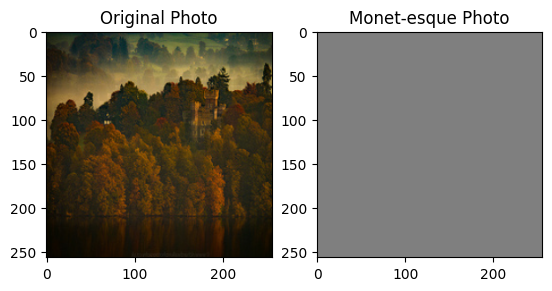

In [21]:
example_photo = next(iter(photo_ds))

to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# Image is grey as we haven't initialized the generator yet

### CycleGan 

Refer to: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial#Build-the-CycleGAN-model

In [22]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Loss Functions

Reference:

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

https://jonathan-hui.medium.com/gan-cyclegan-6a50e7600d7

#### Adversary Loss:

For our discriminator $D$, our loss function sees how well our discriminator ranks real photos $D(y)$ (which should have an output of 1) and generated photos $D(G(x))$ which should have an output of 0.

For our generators $G$, our loss function sees how well our generator function was able to "trick" the discriminator function, for example, if $D(G(x))$ returns 1, the generator has succesfully tricked the discriminator.

In [23]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

#### Identity Loss

Identity loss compares a real image $x$ with its generator $G(x)$ - the higher the output of the loss function, the more we can say the image 'decayed', so to speak.

In [24]:

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

#### Cycle Consistency Loss:

> This is the Cycle consistency loss which measures the L1-norm reconstruction cost for the real image (x → y → reconstructed x) and the Monet paintings (y → x → reconstructed y)

Essentially, this is how similar the transformed photo and original photo are to each other.

In [25]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

### Training the CycleGAN

In [26]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [27]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [28]:
BATCH_SIZE = 64

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=30,
    steps_per_epoch = n_photos // BATCH_SIZE
)

Epoch 1/30


I0000 00:00:1719224787.760504      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


109/109 ━━━━━━━━━━━━━━━━━━━━ 67s 232ms/step - monet_disc_loss: 0.5468 - monet_gen_loss: 7.0442 - photo_disc_loss: 0.5716 - photo_gen_loss: 7.1254
Epoch 2/30


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


109/109 ━━━━━━━━━━━━━━━━━━━━ 59s 232ms/step - monet_disc_loss: 0.3431 - monet_gen_loss: 6.5701 - photo_disc_loss: 0.2564 - photo_gen_loss: 6.6408
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 26s 232ms/step - monet_disc_loss: 0.3106 - monet_gen_loss: 6.8819 - photo_disc_loss: 0.4722 - photo_gen_loss: 7.2329
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 27s 232ms/step - monet_disc_loss: 0.4077 - monet_gen_loss: 5.8988 - photo_disc_loss: 0.5887 - photo_gen_loss: 5.8729
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 27s 232ms/step - monet_disc_loss: 0.4166 - monet_gen_loss: 7.0534 - photo_disc_loss: 0.3828 - photo_gen_loss: 7.0853
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 27s 232ms/step - monet_disc_loss: 0.5734 - monet_gen_loss: 5.6288 - photo_disc_loss: 0.3369 - photo_gen_loss: 5.9818
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 27s 232ms/step - monet_disc_loss: 0.5898 - monet_gen_loss: 5.8434 - photo_disc_loss: 0.3702 - photo_gen_loss: 6.3442
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 27s 232ms/step - monet_disc_l

# 4. Results & Analysis
<a name="paragraph3"></a>



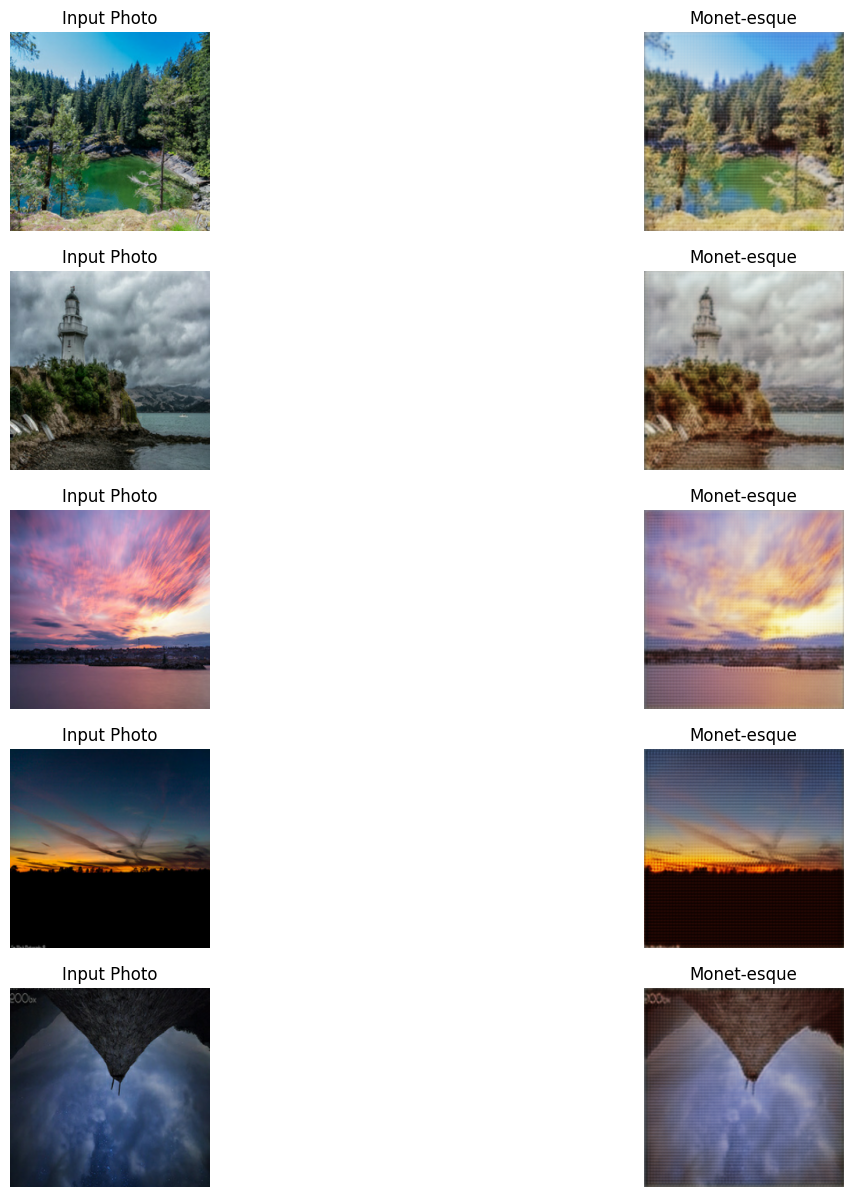

In [29]:
_, ax = plt.subplots(5, 2, figsize=(15, 15))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()


In [30]:
import PIL

os.makedirs('../images/', exist_ok = True) # Create folder to save generated images

i = 1
while i <= 8000:
    for img in photo_ds:
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(prediction)
        im.save(f"../images/" + str(i) + ".jpg")
        i+=1
        if i > 8000:
            break

In [31]:
print(f"Number of generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Number of generated samples: 8000


In [32]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'